<a href="https://colab.research.google.com/github/kemahlitos/AmazonBookReviewSimilarity/blob/main/massive_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**YUSUF KEMAHLI** -
**ALGORITHMS FOR MASSIVE DATASETS PROJECT**

In [52]:
import os

os.environ['KAGGLE_USERNAME'] = "..."
os.environ['KAGGLE_KEY'] = "..."

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

!unzip -q amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
A




In [55]:
import pandas as pd
import random
import re
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# Loads and preproceses data
def load_data(path, sample_size=1000, full_size=False):
    df = pd.read_csv(path)
    df = df.dropna(subset=['Id','review/text'])

    if not full_size:
        df = df.sample(n=sample_size, random_state=10)

    df = df.drop_duplicates()

    return df[['Id', 'review/text']].reset_index(drop=True);

In [57]:
# creates shingles from a text, each shingle with k many words.
def shingle(text, k=5):
    # removes punctuation and lowercase everything
    words = re.findall(r'\w+', text.lower())
    # removes stopwords
    filtered = [w for w in words if w not in stop_words]
    return set([' '.join(filtered[i:i+k]) for i in range(len(filtered) - k + 1)])

In [60]:
# creates shingles for each text and add new shingles column to dataframe
def shingle_all(my_df, k):
    my_df['shingles'] = my_df['review/text'].apply(lambda x: shingle(x, k))
    my_df = my_df[my_df['shingles'].apply(lambda x: len(x) > 0)].reset_index(drop=True) #important cleaning of empty set shingles, which reduce false candidates
    return my_df

In [61]:
# creates n-many hash_functions, for signature creation
def generate_hash_functions(n):
    p = 4294967311 # big prime number
    return [lambda x, a=random.randint(1, p-1), b=random.randint(0, p-1): (a * x + b) % p for _ in range(n)]

In [62]:
# creates signature value for each shingle. so creates a vector like n-rows(hash functions) with one column(set number like set0)
def compute_signature(shingle_set, hash_functions):
    signature = []
    # calculates hash values for each shingle then finds min between n-many value and adds this to matrix
    for h in hash_functions:
        min_val = float('inf')
        for s in shingle_set:
            val = h(hash(s))
            if val < min_val:
                min_val = val
        signature.append(min_val)
    return signature

In [63]:
def compute_signatures_all(df, hash_functions):
    df['signature'] = df['shingles'].apply(lambda s: compute_signature(s, hash_functions))

In [64]:
#  aproximates Jaccard similarity by comparing two MinHash signatures
def approximate_jaccard(sig1, sig2):
    matches = sum(1 for a, b in zip(sig1, sig2) if a == b)
    return matches / len(sig1)

In [65]:
# this func creates candidates in bands
def lsh_create_candidates(df,bands,rows):
    assert bands * rows == len(df['signature'].iloc[0]), "bands x rows must equal signature length"

    buckets = [defaultdict(set) for _ in range(bands)] # we created a bucket dictionary
    signature_list = df['signature'].tolist()
    candidates = set()
    # index means: row index of signature ,so index of review text
    for index, signature in enumerate(signature_list):
        for b in range(bands):
            start = b * rows
            end = start + rows
            signature_band = tuple(signature[start:end])  # creates one band with part of signature

            if signature_band in buckets[b]: #checks do we have this signature part already in bucket for this band index, for example do whe have [0,1,2] in first band in the whole bucket
                for other in buckets[b][signature_band]: #if it finds add pair of most likely pairs, a.k.a candidates
                    pair = tuple(sorted((index, other)))
                    candidates.add(pair)
            buckets[b][signature_band].add(index) #  adds new index to signature band

    return candidates

In [66]:
# to create candidate pairs
def find_similar_pairs(df, candidate_pairs, threshold=0.8, m=5):

    results = []

    for i, j in candidate_pairs:
        sig1 = df.iloc[i]['signature']
        sig2 = df.iloc[j]['signature']

        if sig1[:m] != sig2[:m]:
            continue  # to obtain fast minhasing

        if len(df.iloc[i]['shingles']) < 1 or len(df.iloc[j]['shingles']) < 1:
            continue


        sim = approximate_jaccard(sig1, sig2)
        if sim >= threshold:
            results.append((i, j, sim))


    return results

In [74]:
# constructs result dataframe
def build_results_table(df, similar_pairs, max_text_length=150):

    results = []

    for i, j, sim in similar_pairs:
        id1 = df.iloc[i]['Id']
        id2 = df.iloc[j]['Id']
        text1 = df.iloc[i]['review/text'][:max_text_length].replace('\n', ' ')
        text2 = df.iloc[j]['review/text'][:max_text_length].replace('\n', ' ')
        results.append({
            'BookID 1': id1,
            'BookID 2': id2,
            'Similarity': round(sim, 3),
            'Review 1': text1,
            'Review 2': text2
        })

    return pd.DataFrame(results)

In [101]:
# global variables
path= "Books_rating.csv"
sample_size=100000
full_size=False
k=5
num_funcs = 100
bands=20
rows=5
threshold=0.8
m=5

In [102]:
%%time
def main():
  df = load_data(path, sample_size, full_size)
  df = shingle_all(df,k)
  hash_funcs = generate_hash_functions(num_funcs)
  compute_signatures_all(df, hash_funcs)
  candidates = lsh_create_candidates(df, bands, rows)
  similar_pairs = find_similar_pairs(df, candidates, threshold, m)
  results_df = build_results_table(df, similar_pairs)
  return results_df

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [103]:
%%time
results = main()

CPU times: user 7min 16s, sys: 6.08 s, total: 7min 22s
Wall time: 7min 29s


In [104]:
results

,BookID 1,BookID 2,Similarity,Review 1,Review 2
0,B0006CGN5I,B00086RA0O,1.00,"There are many books, indeed series, which att...","There are many books, indeed series, which att..."
1,B000R4SOGG,B000BI4VM4,1.00,I've always wanted to read the book behind the...,I've always wanted to read the book behind the...
2,B000PC54NG,B000H9R1Q0,1.00,"I don't know what to say of this book, everyon...","I don't know what to say of this book, everyon..."
3,0192503561,9999868134,1.00,This is the last novel that Jane Austen finish...,This is the last novel that Jane Austen finish...
4,B000K7WNQW,0808510258,0.98,Harper Lee was encouraged to write some of her...,Harper Lee was encouraged to write some of her...
...,...,...,...,...,...
3865,B000PCESRE,B000PMCF1A,1.00,This book is known as a classic for it's simpl...,This book is known as a classic for it's simpl...
3866,B0006ARW8M,0748608370,1.00,My son listened to this audio book as he read ...,My son listened to this audio book as he read ...
3867,B000PZU6P4,B0006BVGA6,1.00,I did not purchase this book for his thoughts ...,I did not purchase this book for his thoughts ...
3868,B000GQG7D2,B000GQG5MA,1.00,I first read the Hobbit when I was a teenager....,I first read the Hobbit when I was a teenager....


In [105]:
results.sort_values(by="Similarity", ascending=True).head(10)


,BookID 1,BookID 2,Similarity,Review 1,Review 2
1289,9626341823,B000NYRZ42,0.80,We would be hard pressed to find people not fa...,We would be hard pressed to find people not fa...
3694,B00086Q4RO,B0006APNP6,0.84,I hear the word boring used quite often these ...,I hear the word boring used quite often these ...
3123,9562910512,B0006APNP6,0.84,I hear the word boring used quite often these ...,I hear the word boring used quite often these ...
2874,B000NPQOMA,B000875HJE,0.85,This was the ONLY book I got to read on my new...,"I really wanted to read this book, it is one I..."
1895,B000PMCF1A,B000PCESRE,0.85,"Jonas' opinion of ""The Catcher in the Rye"", by...",(...)I find it a very good novel because it le...
3672,0553502158,B000N79P10,0.85,For years I have read every Daniell Steel book...,"I enjoyed reading this book, and would suggest..."
163,158726398X,1578152445,0.88,Great Expectations was a mediocre book. I was ...,Great Expectations was a mediocre book. I was ...
2261,0809594528,1578152445,0.88,Great Expectations was a mediocre book. I was ...,Great Expectations was a mediocre book. I was ...
3452,0976866056,0976866056,0.89,"I have just returned from Crosswind PM, Inc.'s...","I have just returned from Crosswind PM, Inc.'s..."
2000,B0008CRBJS,B00071O7VK,0.90,This book is so widely cited and interpreted c...,This book is so widely cited and interpreted c...


**TESTS AND RESULTS**

In [86]:
%%time
df_full = load_data(path="Books_rating.csv", sample_size=None, full_size=True)


CPU times: user 1min, sys: 2.39 s, total: 1min 2s
Wall time: 1min 3s


In [87]:
import time

sample_sizes = [1000, 5000, 25000, 125000]
timings = []

for size in sample_sizes:
    df = df_full.sample(n=size, random_state=10).reset_index(drop=True)

    t0 = time.time()
    df = shingle_all(df,k)
    hash_funcs = generate_hash_functions(num_funcs)
    compute_signatures_all(df, hash_funcs)
    candidates = lsh_create_candidates(df, bands=20, rows=5)
    similar_pairs = find_similar_pairs(df, candidates, threshold=0.8, m=5)
    t1 = time.time()

    duration = t1 - t0
    timings.append((size, duration, len(candidates), len(similar_pairs)))

    print(f"{size} rows → {duration:.2f} sec | {len(candidates)} candidates | {len(similar_pairs)} similar pairs")


1000 rows → 3.21 sec | 1 candidates | 1 similar pairs
5000 rows → 19.88 sec | 10 candidates | 9 similar pairs
25000 rows → 96.29 sec | 256 candidates | 247 similar pairs
125000 rows → 516.06 sec | 6002 candidates | 5847 similar pairs


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(timings, columns=["sample_size", "runtime_sec", "candidates", "similar_pairs"])
display(results_df)


,sample_size,runtime_sec,candidates,similar_pairs
0,1000,3.209158,1,1
1,5000,19.884023,10,9
2,25000,96.285167,256,247
3,125000,516.063803,6002,5847


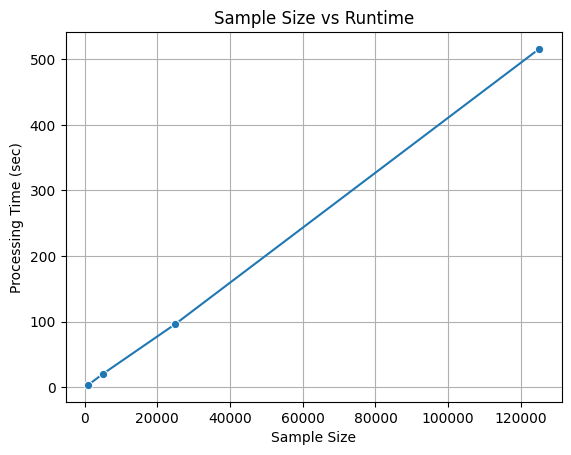

In [89]:
sns.lineplot(data=results_df, x="sample_size", y="runtime_sec", marker="o")
plt.title("Sample Size vs Runtime")
plt.xlabel("Sample Size")
plt.ylabel("Processing Time (sec)")
plt.grid(True)
plt.show()

In [90]:
%%time
sample_size = 100000
k = 5
num_funcs = 100
m = 5

df_sample = df_full.sample(n=sample_size, random_state=10).reset_index(drop=True)

df_sample = shingle_all(df_sample, k)
hash_funcs = generate_hash_functions(num_funcs)
compute_signatures_all(df_sample, hash_funcs)


CPU times: user 6min 31s, sys: 1.17 s, total: 6min 32s
Wall time: 6min 35s


In [91]:
band_configs = [(10,10), (20,5), (25,4), (50,2)]
br_results = []

for b, r in band_configs:
    start = time.time()
    candidates = lsh_create_candidates(df_sample, bands=b, rows=r)
    similar_pairs = find_similar_pairs(df_sample, candidates, threshold=0.8, m=m)
    end = time.time()

    br_results.append({
        'bands': b,
        'rows': r,
        'candidates': len(candidates),
        'similar_pairs': len(similar_pairs),
        'time': round(end - start, 2)
    })

for res in br_results:
    print(res)


{'bands': 10, 'rows': 10, 'candidates': 3886, 'similar_pairs': 3821, 'time': 11.4}
{'bands': 20, 'rows': 5, 'candidates': 3947, 'similar_pairs': 3821, 'time': 15.24}
{'bands': 25, 'rows': 4, 'candidates': 3953, 'similar_pairs': 3821, 'time': 16.84}
{'bands': 50, 'rows': 2, 'candidates': 4467, 'similar_pairs': 3821, 'time': 37.33}


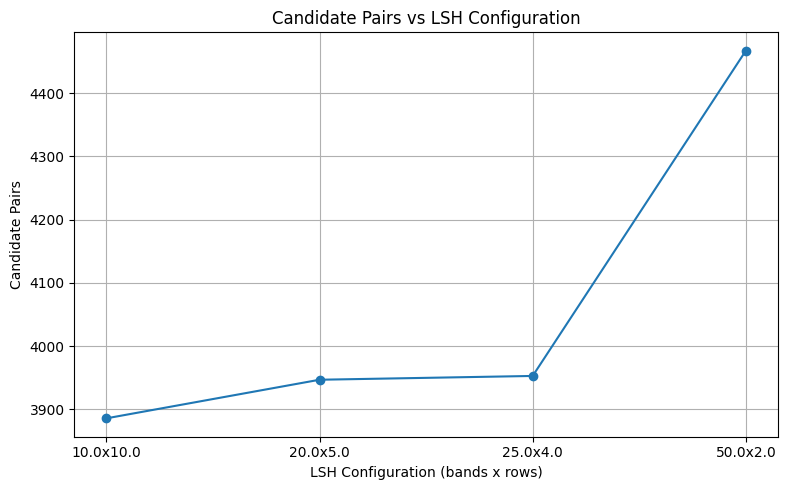

In [92]:
df = pd.DataFrame(br_results)
df['config'] = df.apply(lambda row: f"{row['bands']}x{row['rows']}", axis=1)

# plots
plt.figure(figsize=(8, 5))
plt.plot(df['config'], df['candidates'], marker='o', color='tab:blue')
plt.title('Candidate Pairs vs LSH Configuration')
plt.xlabel('LSH Configuration (bands x rows)')
plt.ylabel('Candidate Pairs')
plt.grid(True)
plt.tight_layout()
plt.show()


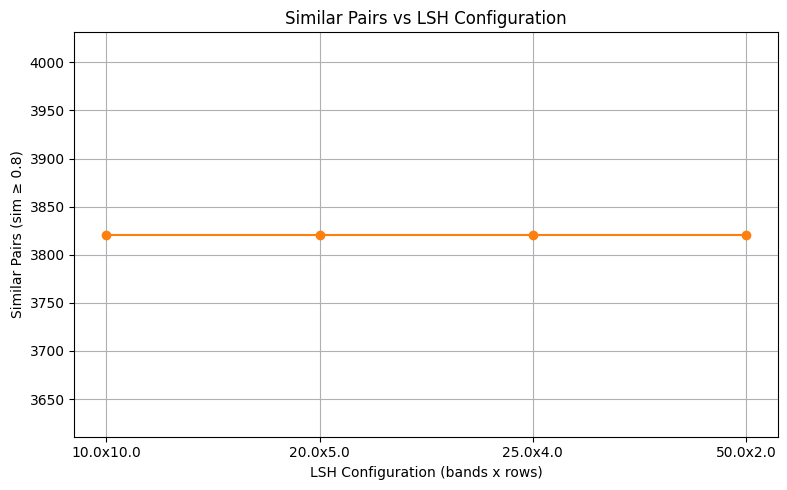

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(df['config'], df['similar_pairs'], marker='o', color='tab:orange')
plt.title('Similar Pairs vs LSH Configuration')
plt.xlabel('LSH Configuration (bands x rows)')
plt.ylabel('Similar Pairs (sim ≥ 0.8)')
plt.grid(True)
plt.tight_layout()
plt.show()

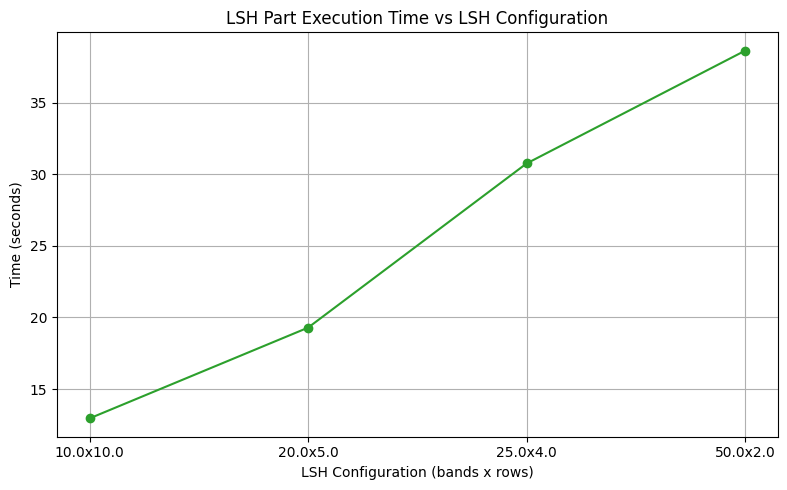

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df['config'], df['time'], marker='o', color='tab:green')
plt.title('LSH Part Execution Time vs LSH Configuration')
plt.xlabel('LSH Configuration (bands x rows)')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
k_values = [3, 5, 7]
results = []

for k_val in k_values:
    df_sample = df_full.sample(n=100000, random_state=10).reset_index(drop=True)

    t0 = time.time()
    df_sample = shingle_all(df_sample, k=k_val)
    hash_funcs = generate_hash_functions(100)
    compute_signatures_all(df_sample, hash_funcs)
    candidates = lsh_create_candidates(df_sample, bands=20, rows=5)
    similar_pairs = find_similar_pairs(df_sample, candidates, threshold=0.8, m=5)
    t1 = time.time()

    results.append({
        'k': k_val,
        'candidates': len(candidates),
        'similar_pairs': len(similar_pairs),
        'time': round(t1 - t0, 2)
    })

for row in results:
    print(row)


{'k': 3, 'candidates': 3973, 'similar_pairs': 3875, 'time': 419.01}
{'k': 5, 'candidates': 3935, 'similar_pairs': 3853, 'time': 388.3}
{'k': 7, 'candidates': 3909, 'similar_pairs': 3808, 'time': 392.03}


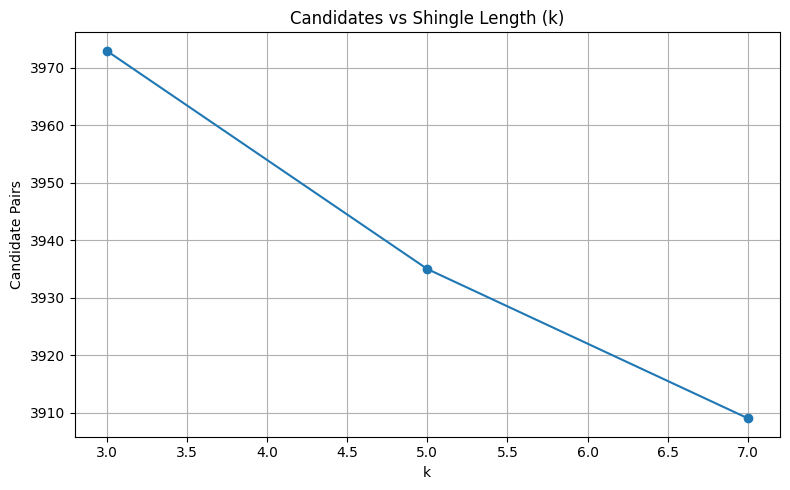

In [96]:
df_k = pd.DataFrame(results)

plt.figure(figsize=(8, 5))
plt.plot(df_k['k'], df_k['candidates'], marker='o')
plt.title('Candidates vs Shingle Length (k)')
plt.xlabel('k')
plt.ylabel('Candidate Pairs')
plt.grid(True)
plt.tight_layout()
plt.show()


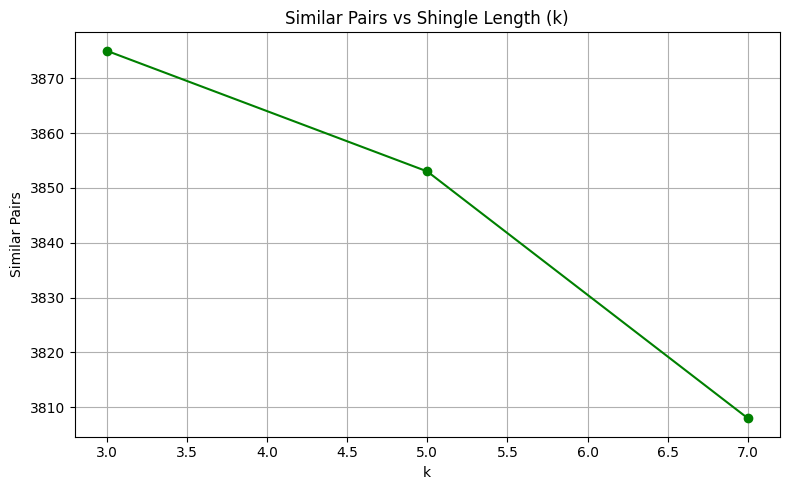

In [99]:
plt.figure(figsize=(8, 5))
plt.plot(df_k['k'], df_k['similar_pairs'], marker='o', color='green')
plt.title('Similar Pairs vs Shingle Length (k)')
plt.xlabel('k')
plt.ylabel('Similar Pairs')
plt.grid(True)
plt.tight_layout()
plt.show()

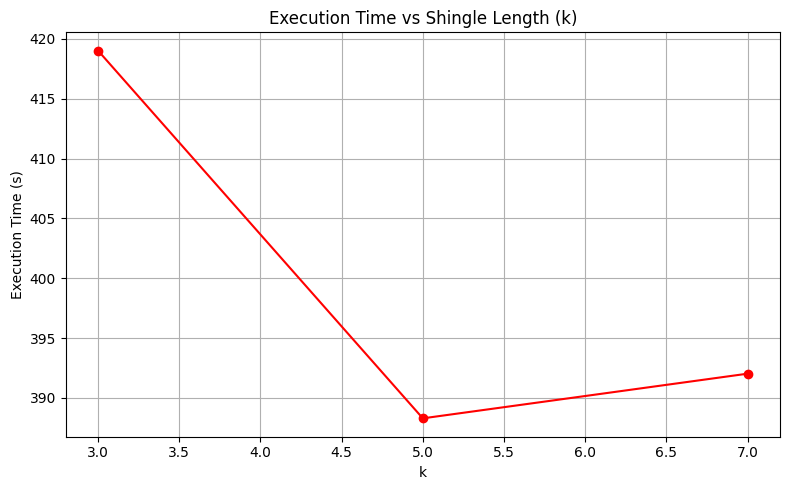

In [98]:
plt.figure(figsize=(8, 5))
plt.plot(df_k['k'], df_k['time'], marker='o', color='red')
plt.title('Execution Time vs Shingle Length (k)')
plt.xlabel('k')
plt.ylabel('Execution Time (s)')
plt.grid(True)
plt.tight_layout()
plt.show()
